In [118]:
import enchant
from enchant.checker import SpellChecker
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import plotly.express as px
import textwrap
import spacy
import langdetect
from collections import Counter
import re

In [2]:
nlp = spacy.load('en_core_web_lg', max_length=2000000)

In [3]:
def removeEnts(text): 
    textDoc = nlp(text)
    noEnts = [w for w in textDoc if w.ent_type_ == '']
    noEntsTexts = [str(w) for w in noEnts]
    return ' '.join(noEntsTexts)

In [4]:
def getMisspelled(text): 
    checker = SpellChecker('en_GB')    
    noEnts = removeEnts(text)
    checker.set_text(noEnts)
    misspelledWords = []
    for w in checker: 
        misspelledWords.append(w.word)
    return misspelledWords

def getNumMisspelled(text): 
    return len(getMisspelled(text))

In [98]:
wake = open('../finnegans-wake-tei/finnegans-wake.xml').read()
soup = BeautifulSoup(wake)
wakeText = soup.get_text()[1055:]

In [86]:
ulysses = open('/home/jon/Dokumentujo/Research/Corpora/pg-text/1922-JoyceJames-Ulysses-4300.0').read()

In [119]:
re.findall('-- .*? --', ulysses)

['-- I --', '-- II --', '-- III --']

In [113]:
def getSegments(text, n=50):
    binA = list(range(0, len(text), round(len(text)/n)))
    ranges = list((zip(binA, binA[1:])))
    segments = []
    for i, j in ranges: 
        segments.append(text[i:j])
    return segments

In [114]:
def misspelledDf(text): 
    segments = getSegments(text)
    misspelledN = [getNumMisspelled(seg) for seg in segments]
    s = pd.Series(misspelledN) #.plot(kind='bar')
    df = pd.DataFrame(s, index=s.index, columns=['nMisspelled'])
    df['segment'] = df.index
    previews = [textwrap.wrap(seg[:150], 40) for seg in segments]
    df['previews'] = previews
    misspelled = [' '.join(getMisspelled(seg))[:150] for seg in segments]
    df['misspelled'] = misspelled
    return df

In [115]:
def plotMisspelled(text): 
    df = misspelledDf(text)
    fig = px.bar(df, x='segment', y='nMisspelled', hover_data=['previews', 'misspelled'])
    fig.show()

In [109]:
plotMisspelled(wakeText)

In [116]:
plotMisspelled(ulysses)

# Try to detect the languages

In [61]:
def guessLanguageProportions(text): 
    """ First method: sum all the individual probabilities for each sentence. """
    allProps = {}
    doc = nlp(text)
    for sent in doc.sents: 
        sent = sent.text
        try: 
            langs = langdetect.detect_langs(sent)
        except: 
            #print("Error on: ", sent)
            continue
        for lang in langs:
            l, prob = lang.lang, lang.prob
            if l in allProps:
                allProps[l] += prob
            else: 
                allProps[l] = prob
    return allProps

In [73]:
def languageProportions(text): 
    """ Second method: get the highest-scoring language for each sentence, and tally 
    them according to number of sentences.
    """
    allProps = {}
    doc = nlp(text)
    for sent in doc.sents: 
        sent = sent.text
        try: 
            lang = langdetect.detect(sent)
        except: 
            #print("Error on: ", sent)
            continue
        if lang in allProps:
            allProps[lang] += 1
        else: 
            allProps[lang] = 1
#         if lang != 'en': 
#             print(sent, lang)
    return allProps

<AxesSubplot:>

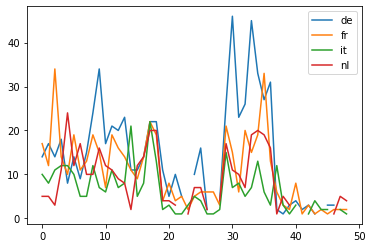

In [121]:
pd.DataFrame(props)[['de', 'fr', 'it', 'nl']].plot()
#pd.DataFrame(props)['en'].plot()

In [122]:
def plotLanguageProportions(segments, langs=['en']): 
    props = [languageProportions(seg) for seg in segments]
    pd.DataFrame(props)[langs].plot()

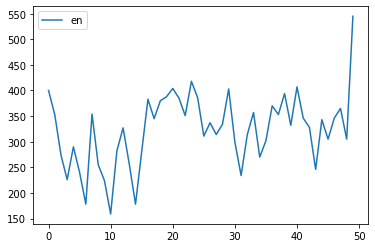

In [124]:
plotLanguageProportions(getSegments(wakeText))

In [125]:
plotLanguageProportions(getSegments(wakeText), langs=[['de', 'fr', 'it', 'nl']])

KeyError: "None of [Index([('de', 'fr', 'it', 'nl')], dtype='object')] are in the [columns]"

In [130]:
def colemanLiau(text): 
    """ Computes the Coleman-Liau readability index for a text."""
    doc = nlp(text)
    numLetters = len(text)
    numWords = len(doc) 
    numSents = len(list(doc.sents))
    l = (numLetters/numWords)*100
    s = (numSents/numWords)*100
    return 0.0588*l - 0.296*s - 15.8

In [131]:
segments[0][:200]

"\xa0\xa0\xa0 riverrun, past Eve and Adam's, from swerve of shore to bend\nof bay, brings us by a commodius vicus of recirculation back to\nHowth Castle and Environs.\n\xa0\xa0\xa0\xa0 Sir Tristram, violer d'amores, fr'over t"

In [132]:
colemanLiau(ulysses[:2000])

8.303636363636361

In [133]:
clUlysses = [colemanLiau(seg) for seg in getSegments(ulysses)]

<AxesSubplot:>

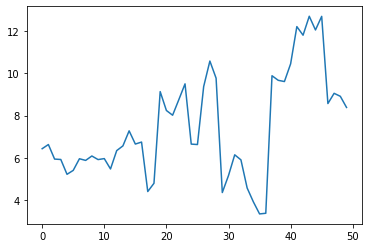

In [134]:
pd.Series(clUlysses).plot()

<AxesSubplot:>

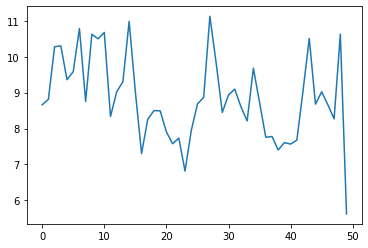

In [135]:
pd.Series([colemanLiau(seg) for seg in getSegments(wakeText)]).plot()